# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.5 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-xobl1qwe
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-xobl1qwe
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (3/3), done.


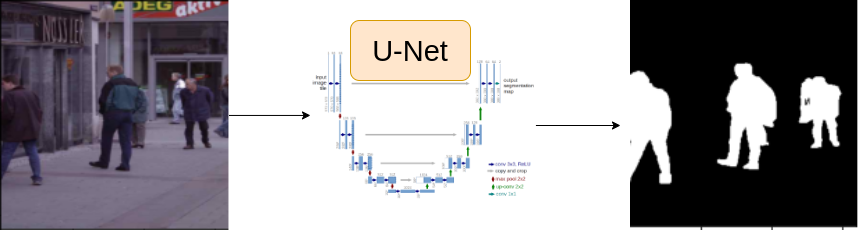

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [12]:
row = df.iloc[40]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.


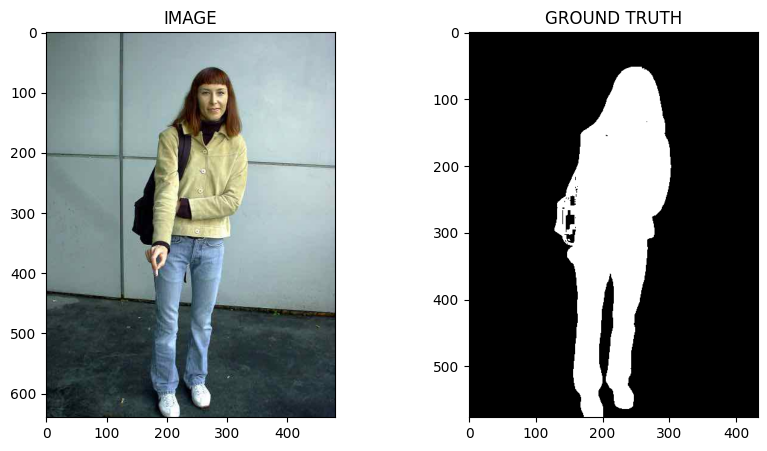

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [43]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [44]:
from torch.utils.data import Dataset

In [45]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations= augmentations

  def __len__(self):
    return  len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w,c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.tensor(image) / 255.
    mask = torch.round(torch.tensor(mask) /255.)

    return image, mask

In [46]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [47]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


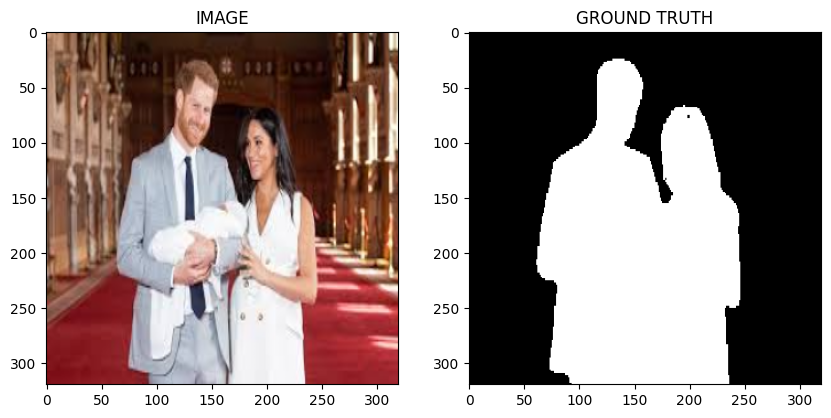

In [48]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [49]:
from torch.utils.data import DataLoader

In [50]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [51]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [52]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [53]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [79]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [80]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [81]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [82]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [84]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1} Train loss : {train_loss} Valid loss{valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


SAVED-MODEL
Epoch : 1 Train loss : 0.7618517140547435 Valid loss2.8738322257995605


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.35831588705380757 Valid loss0.3021085895597935


100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.3282486895720164 Valid loss0.28071341663599014


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 4 Train loss : 0.280960276722908 Valid loss0.36321714520454407


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 5 Train loss : 0.2975895682970683 Valid loss0.2940540798008442


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


SAVED-MODEL
Epoch : 6 Train loss : 0.22360684076944987 Valid loss0.2171892449259758


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


SAVED-MODEL
Epoch : 7 Train loss : 0.21137588719526926 Valid loss0.20280074700713158


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


Epoch : 8 Train loss : 0.23730000456174213 Valid loss0.2138347141444683


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch : 9 Train loss : 0.20494458675384522 Valid loss0.21150857210159302


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch : 10 Train loss : 0.18134162425994874 Valid loss0.2688627727329731


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch : 11 Train loss : 0.15871362288792928 Valid loss0.228937029838562


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch : 12 Train loss : 0.1691400910417239 Valid loss0.2501649856567383


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch : 13 Train loss : 0.20313217093547184 Valid loss0.24432210996747017


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


SAVED-MODEL
Epoch : 14 Train loss : 0.16645529121160507 Valid loss0.1958591490983963


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch : 15 Train loss : 0.1549137552579244 Valid loss0.21155529469251633


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 16 Train loss : 0.16889040519793827 Valid loss0.2596176713705063


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch : 17 Train loss : 0.1449068506558736 Valid loss0.2412116453051567


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch : 18 Train loss : 0.13790294528007507 Valid loss0.21040372550487518


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 19 Train loss : 0.12006566574176153 Valid loss0.24954024702310562


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


SAVED-MODEL
Epoch : 20 Train loss : 0.18646612912416458 Valid loss0.19070959463715553


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch : 21 Train loss : 0.14893633325894673 Valid loss0.19471890106797218


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 22 Train loss : 0.14814961850643157 Valid loss0.20397479832172394


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 23 Train loss : 0.12016156266132991 Valid loss0.20526250824332237


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch : 24 Train loss : 0.10221802691618602 Valid loss0.19428285211324692


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


SAVED-MODEL
Epoch : 25 Train loss : 0.10470192929108937 Valid loss0.16652855277061462


# Task 9 : Inference

In [102]:
idx = 11

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.

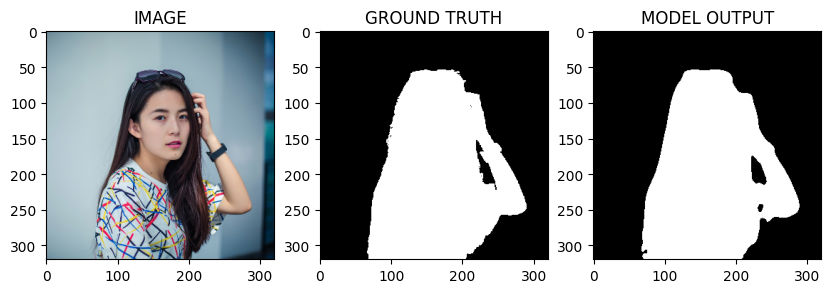

In [103]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya